# Generating Snythetic Data
---

want to modify SEM so that there's hidden confounding that breaks markovianity so that Markov Equivalence Class isn't good enough.

## Known SEM:
Variables  
**is_senior**: Binary  
**sale_calls**: Non-negative integer  
**interactions**: Non-negative integer  
**bugs_faced**: Non-negative integer  
**monthly_usage**: Non-negative integer  
**consumer_trust**: Integer (0 to 5)  
**discount**: Integer (0 to 4)  
**renewal**: Outcome variable (binary)

The "Setting" Variables:  
**is_senior** $\sim \text{Binomial}(1, 0.25, n)$  
**sale_calls** $\sim \text{Poisson}(3, n)$  
**bugs_faced** $\sim \text{Poisson}(3, n)$  
**consumer_trust** $\text{round}(4\text{beta}(3,2,n) + 1)$

Structural Equations  
**Interactions** $ = \begin{cases} \alpha_1 e^{-\beta_1 \cdot \text{sales\_call}} \text{ if is senior } = 0: \\
\gamma_1 \left(1 - e^{-\delta_1 \cdot \text{sales\_call}}\right) \text{ if is senior} = 1: \end{cases}$

**Discount**: $ = \alpha_2 \cdot \text{bugs\_faced} + \beta_2 \cdot \text{monthly\_usage} + \epsilon_1$  
   where $\alpha_2$ and $\beta_2$ are coefficients, and $\epsilon_1$ is the error term.  

**Logit(Renewal)**: $ = \alpha_3 \cdot \text{interactions} - \beta_3 \cdot \text{bugs\_faced} + \gamma_3 \cdot \text{monthly\_usage} + \delta_3 \cdot \text{consumer\_trust} - \lambda_3 \cdot \text{discount} + \epsilon_2$  
   where $\alpha_3$, $\beta_3$, $\gamma_3$, $\delta_3$, and $\lambda_3$ are coefficients, and $\epsilon_2$ is the error term.


## Justification  
- **Interactions**:
  - For non-seniors (`is_senior` = 0), interactions decrease rapidly with increasing sale_calls.
  - For seniors (`is_senior` = 1), interactions increase with increasing sale_calls.
  
- **Discount** is influenced by the number of bugs_faced and monthly_usage.
  
- **Renewal** probability (logit-transformed) is influenced by interactions, bugs_faced, monthly_usage, consumer trust, and discount.

In [1]:
import numpy as np
import pandas as pd
import sympy as sp
import networkx as nx
import matplotlib.pyplot as plt

import random
import string

In [2]:
# problem, bugs_faced should heavily dependent on monthly usage !!

np.random.seed(42)
n_samples = 100000

data = {
    'is_senior': np.random.binomial(1, 0.25, n_samples),
    'sale_calls': np.random.poisson(3, n_samples),
    'bugs_faced': np.random.poisson(2, n_samples),
    'monthly_usage': np.random.poisson(10, n_samples),
    # 'consumer_trust': np.round(np.random.triangular(0, 4, 5, n_samples)),
    # 'consumer_trust': np.round(skewnorm.rvs(4, size=n_samples, loc=4, scale=1)),
    'consumer_trust': np.round(1 + 4 * np.random.beta(3, 2, n_samples)).astype(int),
    }

df = pd.DataFrame(data)

df['interactions'] = np.where(
    df['is_senior'] == 0,
    np.exp(-0.5 * df['sale_calls']),
    1 - np.exp(-0.3 * df['sale_calls']))

# discount dependant on bugs_faced and monthly_usage with some noise
df['discount'] = (0.5 * df['bugs_faced'] + 0.3 * df['monthly_usage'] + np.random.normal(0, 1, n_samples)).astype(int)
df['discount'] = df['discount'].clip(0, 4)  # discount is between 0 and 4

# renewal dependant on interactions, bugs_faced, monthly_usage, consumer_trust discount
logit_renewal = (
      df['interactions'] 
    - 0.5 * df['bugs_faced'] 
    + 0.3 * df['monthly_usage'] 
    + 0.2 * df['consumer_trust']
    - 0.4 * df['discount']
    + np.random.normal(0, 1, n_samples)
)
df['renewal'] = (logit_renewal > 0).astype(int)
# categorize renewel to true/false boolean type
# df['renewal'] = df['renewal'].astype('bool')

## SymPy SEM:

In [3]:
# is_senior: IS, sale_calls: SC, bugs_faced: BF, monthly_usage: U, consumer_trust: CT 
IS, SC, BF, U, CT = sp.symbols('IS SC BF U CT')
discount = sp.floor(sp.Min(sp.Max(0.5 * BF + 0.3 * U, 0), 4) + 0.5)
# discount = sp.Min(sp.Max(0.5 * BF + 0.3 * U, 0), 4)

interactions = sp.Piecewise(
    (sp.exp(-0.6 * SC), sp.Eq(IS, 0)),
    (1 - sp.exp(-0.3 * SC), True))

logit_renewal = interactions - 0.5 * BF + 0.3 * U + 0.2 * CT - 0.4 * discount
renewal = sp.Heaviside(logit_renewal)

renewal_function = sp.Lambda((IS, SC, BF, U, CT), renewal)
renewal_function(0, 100, 20, 50, 2) # SEM
renewal_function

## then want to compare SEM's interventions & countefactuals on the causalnex model.
# # renewal_function(is_senior, sale_calls, bugs_faced, monthly_usage, consumer_trust)
# renewal_function(0, 100, 20, 20, 1)

discount

floor(Min(4, Max(0, 0.5*BF + 0.3*U)) + 0.5)

## Ground Truth DAG:

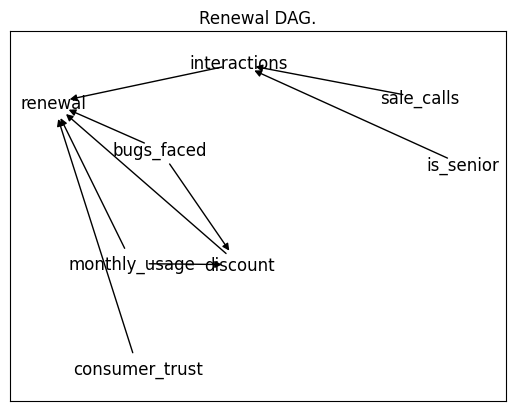

In [24]:
edges = [('is_senior', 'interactions'),
         ('sale_calls', 'interactions'),
         ('interactions', 'renewal'),
         ('bugs_faced', 'renewal'),
         ('bugs_faced', 'discount'),
         ('monthly_usage', 'renewal'),
         ('monthly_usage', 'discount'),
         ('consumer_trust', 'renewal'),
         ('discount', 'renewal')]

G = nx.DiGraph()
nodes = ["is_senior", "sale_calls", "bugs_faced", "monthly_usage", "consumer_trust", "interactions", "discount", "renewal"]
G.add_nodes_from(nodes)
G.add_edges_from(edges)
nx.draw_networkx(G, arrows = True, node_shape = "s", node_color = "white")
plt.title("Renewal DAG.")
plt.show()

## Dimensionality problem

In [13]:
# df
def gen_postal_code():
    pattern = [string.ascii_letters.upper(), string.digits]*2# *3
    return ''.join(random.choice(group) for group in pattern)
# gen_postal_code()
df['postal_code'] = [gen_postal_code() for _ in range(n_samples)]

In [23]:
df.postal_code

0        S8F5
1        V9Q1
2        C7Y5
3        L5K2
4        K3X1
         ... 
99995    D5O9
99996    O4B1
99997    S1Q4
99998    U1F5
99999    N1P6
Name: postal_code, Length: 100000, dtype: object

In [22]:
len(df.postal_code.unique())

52343